In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
%matplotlib inline 

import matplotlib.patches as mpatches
from PIL import Image
from skimage import io as skimgIO
from skimage.filters import (sobel, threshold_otsu)
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line, resize, rotate,
                               hough_circle, hough_circle_peaks)
from skimage.exposure import histogram
from skimage.feature import canny, corner_harris, corner_peaks, corner_subpix, hog
from skimage.color import (rgb2gray, label2rgb)
from skimage.measure import (label, regionprops)
from skimage import morphology

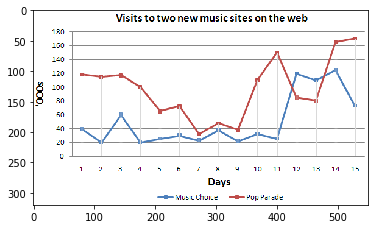

In [12]:
#### line
# 图表数据区域误识别 [36,39,54，71，74，90,7]
# 腐蚀融合不理想 {11， 13}
# y轴label和tick误连 {46， }
# bbox范围小 {49}

#### bar
# bbox范围小 {3}
# 数据区域误识 {4,59}
# 融合不彻底 {14，68}
# {28,84,0}
img_path = './data_test/line_img_failed/real_line_16.png'
#img_path = '/media/lhuan/lhuan/euro_vis/evaluation_data/evalset_fqa/pie/bitmap/369.jpg'
img_ori = skimgIO.imread(img_path)   #<class 'imageio.core.util.Array'>
#plt.imshow(img_ori)
type(img_ori.dtype)
plt.imshow(img_ori)

<class 'numpy.ndarray'> float64
0.705078125
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


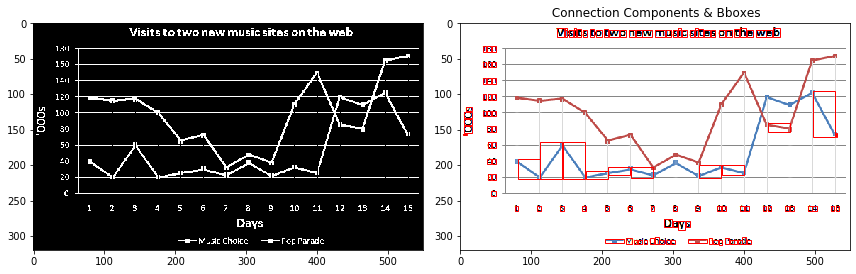

In [13]:
img_gray = rgb2gray(img_ori)   #<class 'numpy.ndarray'>
print(type(img_gray), img_gray.dtype)
# 二值化
thresh = threshold_otsu(img_gray)
print(thresh)
img_binary = img_gray < thresh
print(img_binary)

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.ravel()
ax[0].imshow(img_binary, cmap=c_map.gray)

label_img, label_num = label(img_binary, background=None, return_num=True, connectivity=2)
#image_label_overlay = label2rgb(label_img, image=img_binary)
#plt.imshow(image_label_overlay)

chara_bbox_cent = []
chara_bbox = []
chara_bbox_area = []
label_rm = []
chara_cove_area = []
chara_area = []
chara_rate = []
chara_solid = []

img_height, img_width = img_binary.shape
bbox_thresh = img_width*img_height//32000

ax[1].imshow(img_ori)
regionprop_lst = regionprops(label_img)
label_area_thresh = sorted([i.bbox_area for i in regionprop_lst],reverse=True)
for region in regionprops(label_img):  
    # take regions with large enough areas
    if (img_height*img_width) // 40 >=region.bbox_area >= bbox_thresh \
                and region.eccentricity < 0.993:
            # remove area/凸包面积大于0.97的区域（整体的块状区域，无孔洞）
        if (region.area > 40 and region.solidity <0.9) or region.area <=40:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=1)

            chara_bbox_cent.append(region.centroid)
            chara_bbox.append(region.bbox)
            chara_bbox_area.append(region.bbox_area)
            chara_cove_area.append(region.convex_area)
            chara_area.append(region.area)
            chara_solid.append(region.solidity)
            chara_rate.append(region.area/region.convex_area)
            ax[1].add_patch(rect)
        else:
            label_rm.append(region.label)
    else:
        label_rm.append(region.label)

plt.title(' Connection Components & Bboxes')
#ax.set_axis_off()
# plt.savefig(name)
plt.tight_layout()

In [ ]:
img_height, img_width, label_num, len(label_rm), img_height*img_width // 30000

***************** 4 *******************


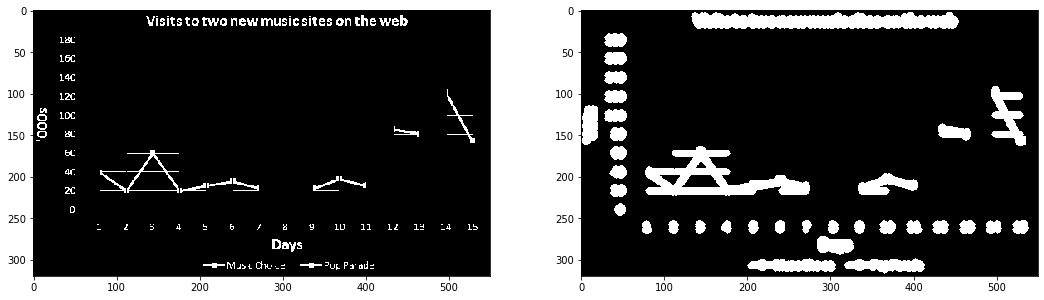

In [14]:
# 将去除干扰元素后的字母元素提取出来
label_rm.append(0)
img_crop = np.isin(label_img, label_rm, invert=True)
fig, ax = plt.subplots(1,2, figsize = (18,9))
ax = ax.ravel()
ax[0].imshow(img_crop, cmap=c_map.gray)

# 腐蚀操作
kernel_size = 6
if img_height*img_width < 400000:
    kernel_size = 5
if img_height*img_width < 200000:
    kernel_size = 4
if img_height*img_width < 100000:
    kernel_size = 3
if img_height*img_width < 70000:
    kernel_size = 2

print("*****************", kernel_size, "*******************")
kernel = morphology.disk(kernel_size)
img_dialtion = morphology.dilation(img_crop, kernel)

ax[1].imshow(img_dialtion, cmap=c_map.gray)

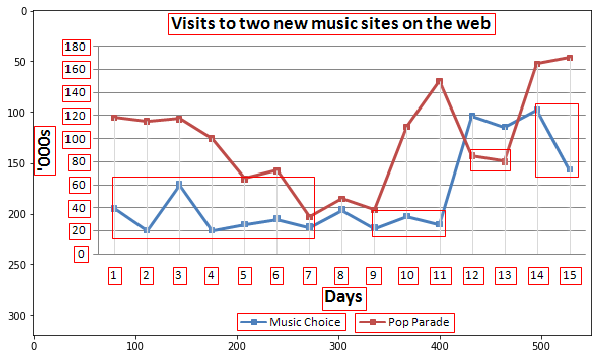

In [15]:
# 腐蚀后再次连通域检测
label_txt, label_num = label(img_dialtion, background=None, return_num=True, connectivity=2)

txt_bbox_cent = []
txt_bbox = []
txt_rotate = []

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_ori)
# see https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations
for region in regionprops(label_txt):  # remove warning in 0.14 vs 0.16
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)
    
    txt_bbox_cent.append(region.centroid)
    txt_bbox.append(region.bbox)
    txt_rotate.append(region.orientation)
    ax.add_patch(rect)
    


In [ ]:
txt_ocr = []
for i, bbox in enumerate(txt_bbox):
    pre_img_array = img_ori[bbox[0]:bbox[2], bbox[1]:bbox[3], :]
    temp_img = Image.fromarray(pre_img_array)
    temp_img.save("txt_bbox_img/"+str(i)+".png")


In [10]:
# ocr文本识别
import pyocr
import pyocr.builders as ocrtools
ocr_tool = pyocr.get_available_tools()[0]
assert ocr_tool is not None, "no ocr_tool acailable!!!"

txt_ocr = []
for bbox in txt_bbox:
    # 将竖向文本旋转90度  TODO
    
    pre_img_array = img_ori[bbox[0]:bbox[2], bbox[1]:bbox[3], :]
    txt = ocr_tool.image_to_string(
                Image.fromarray(pre_img_array),
                lang="eng",
                builder=ocrtools.TextBuilder())
    
    txt_ocr.append(txt)


In [11]:
txt_ocr

['Sludemx‘ anleluina',
 '',
 '',
 '55253 .352',
 '',
 '',
 '',
 '',
 '',
 '',
 'Yellnw',
 'Purple',
 '0mm',
 'mm']

In [ ]:
img_gray = rgb2gray(img_ori)   #<class 'numpy.ndarray'>
print(type(img_gray), img_gray.dtype)
# 二值化
thresh = threshold_otsu(img_gray)
print(thresh)
img_binary = img_gray < thresh*1.1
print(img_binary)

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.ravel()
ax[0].imshow(img_binary, cmap=c_map.gray)

label_img, label_num = label(img_binary, background=None, return_num=True, connectivity=2)
#image_label_overlay = label2rgb(label_img, image=img_binary)
#plt.imshow(image_label_overlay)

chara_bbox_cent = []
chara_bbox = []
chara_bbox_area = []
chara_area = []
label_rm = []
img_height, img_width = img_binary.shape

ax[1].imshow(img_ori)
# see https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations
for region in regionprops(label_img):  # remove warning in 0.14 vs 0.16
    # take regions with large enough areas
    if (img_height*img_width)//40 >=region.bbox_area >= 8 \
        and region.eccentricity < 0.993 :
        if (region.bbox_area > 40 and region.solidity <0.9) or region.bbox_area <=40:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=1)

            chara_bbox_cent.append(region.centroid)
            chara_bbox.append(region.bbox)
            chara_bbox_area.append(region.bbox_area)
            chara_area.append(region.area)
            ax[1].add_patch(rect)
            
        else:
            label_rm.append(region.label)
    else:
        label_rm.append(region.label)

plt.title(' Connection Components & Bboxes')
#ax.set_axis_off()
# plt.savefig(name)
plt.tight_layout()